In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from ipywidgets import interact, fixed
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation
from matplotlib.animation import FFMpegWriter
pd.set_option('max_columns', 100)

import dateutil
from math import radians
from IPython.display import Video

import warnings
warnings.filterwarnings('ignore')
#os.chdir('/Users/Richard/Downloads')
#os.getcwd()
#testing


File descriptions
Game data: The games.csv contains the teams playing in each game. The key variable is gameId.

Player data: The players.csv file contains player-level information from players that participated in any of the tracking data files. The key variable is nflId.

Play data: The plays.csv file contains play-level information from each game. The key variables are gameId and playId.

Tracking data: Files week[week].csv contain player tracking data from all games in week [week]. The key variables are gameId, playId, and nflId. There are 17 weeks to a typical NFL Regular Season, and thus 17 data frames with player tracking data are provided.

Game data
gameId: Game identifier, unique (numeric)

gameDate: Game Date (time, mm/dd/yyyy)

gameTimeEastern: Start time of game (time, HH:MM:SS, EST)

homeTeamAbbr: Home team three-letter code (text)

visitorTeamAbbr: Visiting team three-letter code (text)

week: Week of game (numeric)

Player data
nflId: Player identification number, unique across players (numeric)

height: Player height (text)

weight: Player weight (numeric)

birthDate: Date of birth (YYYY-MM-DD)

collegeName: Player college (text)

position: Player position (text)

displayName: Player name (text)

Play data
gameId: Game identifier, unique (numeric)

playId: Play identifier, not unique across games (numeric)

playDescription: Description of play (text)

quarter: Game quarter (numeric)

down: Down (numeric)

yardsToGo: Distance needed for a first down (numeric)

possessionTeam: Team on offense (text)

playType: Outcome of dropback: sack or pass (text)

yardlineSide: 3-letter team code corresponding to line-of-scrimmage (text)

yardlineNumber: Yard line at line-of-scrimmage (numeric)

offenseFormation: Formation used by possession team (text)

personnelO: Personnel used by offensive team (text)

defendersInTheBox: Number of defenders in close proximity to line-of-scrimmage (numeric)

numberOfPassRushers: Number of pass rushers (numeric)

personnelD: Personnel used by defensive team (text)

typeDropback: Dropback categorization of quarterback (text)

preSnapHomeScore: Home score prior to the play (numeric)

preSnapVisitorScore: Visiting team score prior to the play (numeric)

gameClock: Time on clock of play (MM:SS)

absoluteYardlineNumber: Distance from end zone for possession team (numeric)

penaltyCodes: NFL categorization of the penalties that ocurred on the play. For purposes of this contest, the most important penalties are Defensive Pass Interference (DPI), Offensive Pass Interference (OPI), Illegal Contact (ICT), and Defensive Holding (DH). Multiple penalties on a play are separated by a ; (text)

penaltyJerseyNumber: Jersey number and team code of the player commiting each penalty. Multiple penalties on a play are separated by a ; (text)

passResult: Outcome of the passing play (C: Complete pass, I: Incomplete pass, S: Quarterback sack, IN: Intercepted pass, text)

offensePlayResult: Yards gained by the offense, excluding penalty yardage (numeric)

playResult: Net yards gained by the offense, including penalty yardage (numeric)

epa: Expected points added on the play, relative to the offensive team. Expected points is a metric that estimates the average of every next scoring outcome given the play's down, distance, yardline, and time remaining (numeric)

isDefensivePI: An indicator variable for whether or not a DPI penalty ocurred on a given play (TRUE/FALSE)

Tracking data
Each of the 17 week[week].csv files contain player tracking data from all passing plays during Week [week] of the 2018 regular season. Nearly all plays from each [gameId] are included; certain plays or games with insufficient data are dropped. Each team and player plays no more than 1 game in a given week.

time: Time stamp of play (time, yyyy-mm-dd, hh:mm:ss)

x: Player position along the long axis of the field, 0 - 120 yards. See Figure 1 below. (numeric)

y: Player position along the short axis of the field, 0 - 53.3 yards. See Figure 1 below. (numeric)

s: Speed in yards/second (numeric)

a: Acceleration in yards/second^2 (numeric)

dis: Distance traveled from prior time point, in yards (numeric)

o: Player orientation (deg), 0 - 360 degrees (numeric)

dir: Angle of player motion (deg), 0 - 360 degrees (numeric)

event: Tagged play details, including moment of ball snap, pass release, pass catch, tackle, etc (text)

nflId: Player identification number, unique across players (numeric)

displayName: Player name (text)

jerseyNumber: Jersey number of player (numeric)

position: Player position group (text)

team: Team (away or home) of corresponding player (text)

frameId: Frame identifier for each play, starting at 1 (numeric)

gameId: Game identifier, unique (numeric)

playId: Play identifier, not unique across games (numeric)

playDirection: Direction that the offense is moving (text, left or right)

route: Route ran by offensive player (text)

In [2]:
week1 = pd.read_csv('/Users/Richard/Downloads/week1.csv')
week7 = pd.read_csv('/Users/Richard/Downloads/week7.csv')
week14 = pd.read_csv('/Users/Richard/Downloads/week14.csv')

plays = pd.read_csv('/Users/Richard/Downloads/plays.csv')
players = pd.read_csv('/Users/Richard/Downloads/players.csv')
games = pd.read_csv('/Users/Richard/Downloads/games.csv')

week = pd.concat([week1, week7, week14], ignore_index=True)

In [3]:
games.sample(5)

,gameId,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,week
195,2018120905,12/09/2018,13:00:00,KC,BAL,14
93,2018102107,10/21/2018,13:00:00,NYJ,MIN,7
147,2018111801,11/18/2018,13:00:00,BAL,CIN,11
172,2018112600,11/26/2018,20:15:00,HOU,TEN,12
64,2018100706,10/07/2018,13:00:00,NYJ,DEN,5


In [4]:
plays.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,offenseFormation,personnelO,defendersInTheBox,numberOfPassRushers,personnelD,typeDropback,preSnapVisitorScore,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI
0,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,NaN,NaN,C,10,10,0.261827,False
1,2018090600,146,(13:10) M.Ryan pass incomplete short right to ...,1,1,10,ATL,play_type_pass,PHI,39,SINGLEBACK,"1 RB, 1 TE, 3 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,13:10:00,49.0,NaN,NaN,I,0,0,-0.372360,False
2,2018090600,168,(13:05) (Shotgun) M.Ryan pass incomplete short...,1,2,10,ATL,play_type_pass,PHI,39,SHOTGUN,"2 RB, 1 TE, 2 WR",6.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,13:05:00,49.0,NaN,NaN,I,0,0,-0.702779,False
3,2018090600,190,(13:01) (Shotgun) M.Ryan pass deep left to J.J...,1,3,10,ATL,play_type_pass,PHI,39,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,5.0,"4 DL, 1 LB, 6 DB",SCRAMBLE_ROLLOUT_LEFT,0.0,0.0,13:01:00,49.0,NaN,NaN,C,33,33,3.047530,False
4,2018090600,256,(10:59) (Shotgun) M.Ryan pass incomplete short...,1,3,1,ATL,play_type_pass,PHI,1,SHOTGUN,"2 RB, 3 TE, 0 WR",8.0,6.0,"6 DL, 3 LB, 2 DB",TRADITIONAL,0.0,0.0,10:59:00,11.0,NaN,NaN,I,0,0,-0.842272,False


In [5]:
week.sample(5)

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route
2006132,2018-12-07T02:39:43.799Z,109.00,19.68,1.92,1.27,0.19,282.11,85.07,None,2532848.0,Tashaun Gipson,39.0,FS,24,away,2018120600,1984,right,NaN
1569310,2018-10-21T19:55:40.200Z,76.30,19.97,4.84,1.20,0.49,3.70,293.77,None,2543869.0,Devon Kennard,42.0,OLB,28,away,2018102106,3511,right,NaN
2339800,2018-12-09T19:43:13.000Z,67.14,35.41,5.86,3.58,0.59,215.55,258.08,None,2556370.0,Michael Thomas,13.0,WR,39,away,2018120907,2190,left,NaN
2112467,2018-12-09T18:23:02.099Z,95.96,29.89,7.19,0.99,0.72,24.95,21.89,None,2561132.0,Foye Oluokun,54.0,LB,58,away,2018120903,515,right,NaN
2702162,2018-12-09T21:51:36.099Z,13.67,24.22,1.41,5.15,0.16,318.00,255.24,None,2555528.0,Nick Vigil,59.0,OLB,30,away,2018120909,1094,right,NaN


In [6]:
##Start off by simply plotting a football field

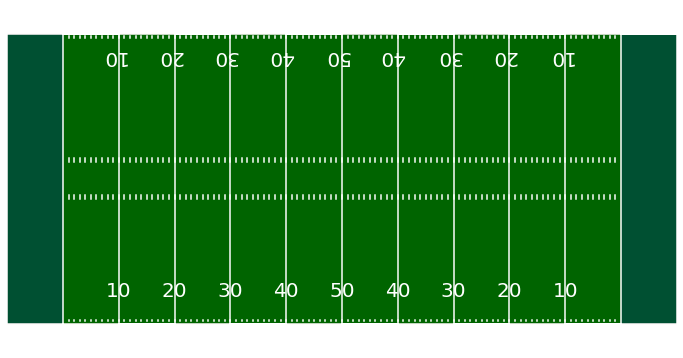

In [7]:
import matplotlib.patches as mpatches

def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = mpatches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = mpatches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = mpatches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax

create_football_field()
plt.show()

In [8]:
week1.event.unique()

array(['None', 'ball_snap', 'pass_forward', 'pass_arrived',
       'pass_outcome_caught', 'out_of_bounds', 'pass_outcome_incomplete',
       'first_contact', 'tackle', 'man_in_motion', 'play_action',
       'qb_sack', 'fumble', 'fumble_offense_recovered', 'handoff',
       'pass_tipped', 'pass_outcome_interception', 'qb_strip_sack',
       'pass_shovel', 'line_set', 'shift', 'touchdown',
       'fumble_defense_recovered', 'pass_outcome_touchdown', 'run',
       'touchback', 'penalty_flag', 'penalty_accepted', 'qb_spike',
       'field_goal_blocked'], dtype=object)

In [9]:
Play_id = 3081
game_id = 2018102102

week1.query("playId == @Play_id").head()

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route
813621,2018-09-10T02:51:32.500Z,84.53,24.78,0.00,0.00,0.01,47.21,1.39,None,80431.0,Clay Matthews,52.0,OLB,1,home,2018090912,3081,left,NaN
813622,2018-09-10T02:51:32.500Z,77.47,11.53,0.19,0.24,0.02,60.77,236.02,None,2506789.0,Tramon Williams,38.0,CB,1,home,2018090912,3081,left,NaN
813623,2018-09-10T02:51:32.500Z,86.02,38.13,0.00,0.00,0.00,216.26,31.78,None,2540200.0,Dion Sims,88.0,TE,1,away,2018090912,3081,left,HITCH
813624,2018-09-10T02:51:32.500Z,69.92,22.29,0.14,0.06,0.02,72.90,60.05,None,2543470.0,Ha Ha Clinton-Dix,21.0,FS,1,home,2018090912,3081,left,NaN
813625,2018-09-10T02:51:32.500Z,86.64,8.39,0.00,0.00,0.00,309.88,159.50,None,2543509.0,Allen Robinson,12.0,WR,1,away,2018090912,3081,left,SCREEN


No handles with labels found to put in legend.


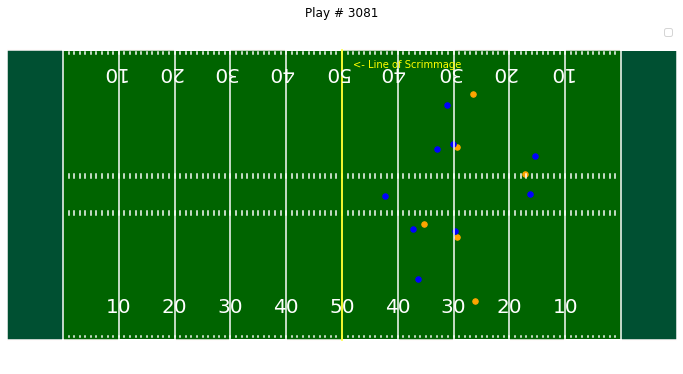

In [10]:
fig, ax = create_football_field(highlight_line=True)
week1.query("event == 'pass_arrived' and playId == @Play_id and team == 'away'") \
    .plot(x='x', y='y', kind='scatter', ax=ax, color='orange', s=30, legend='Away')
week1.query("event == 'pass_arrived' and playId == @Play_id and team == 'home'") \
    .plot(x='x', y='y', kind='scatter', ax=ax, color='blue', s=30, legend='Home')
plt.title(f'Play # {Play_id}')
plt.legend()
plt.show()

In [11]:
#Examine these pass release, pass catch, tackle

No handles with labels found to put in legend.


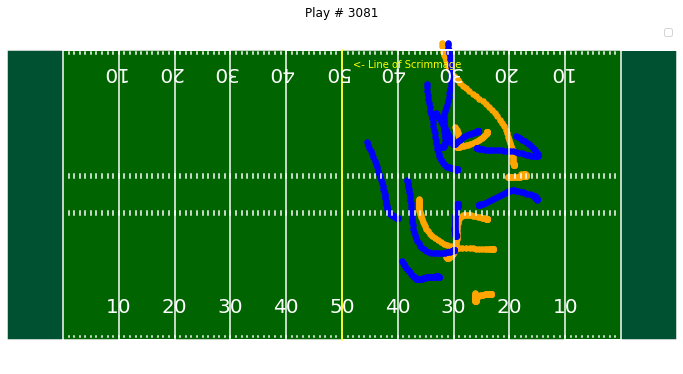

In [12]:
fig, ax = create_football_field(highlight_line=True)
week1.query("playId == @Play_id and team == 'away'") \
    .plot(x='x', y='y', kind='scatter', ax=ax, color='orange', s=30, legend='Away')
week1.query("playId == @Play_id and team == 'home'") \
    .plot(x='x', y='y', kind='scatter', ax=ax, color='blue', s=30, legend='Home')
plt.title(f'Play # {Play_id}')
plt.legend()
plt.show()

## First Analysis

#### Tracking Defensive Shifts with Pre-snap motions
Need to find how much each player moves on defense when the offense uses presnap motion

In [132]:

#setting successful plays to 1 and unsuccessful to 0. Based on whether or not a pass was caught. 
successfulplays = set(week.loc[week.event == 'pass_outcome_caught']['playId'].values)

week['success'] = 0
week.loc[week['playId'].isin(successfulplays), 'success'] = 1


#getting play # with motion plays
play_numbers = set(week.loc[week.event == 'man_in_motion']['playId'].values)

#creating df from those plays
plays_with_motion = week.loc[week.playId.isin(play_numbers)]

plays_with_motion.head()


,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route,success
5210,2018-09-07T01:21:45.500Z,55.58,29.83,0.03,0.03,0.00,259.92,330.66,None,310.0,Matt Ryan,2.0,QB,1,away,2018090600,402,left,NaN,1
5211,2018-09-07T01:21:45.500Z,37.64,27.23,0.09,0.63,0.01,87.72,32.38,None,79848.0,Malcolm Jenkins,27.0,SS,1,home,2018090600,402,left,NaN,1
5212,2018-09-07T01:21:45.500Z,55.10,38.62,0.07,0.06,0.01,272.46,209.39,None,2495454.0,Julio Jones,11.0,WR,1,away,2018090600,402,left,HITCH,1
5213,2018-09-07T01:21:45.500Z,54.95,16.65,0.00,0.00,0.00,281.55,176.75,None,2533040.0,Mohamed Sanu,12.0,WR,1,away,2018090600,402,left,HITCH,1
5214,2018-09-07T01:21:45.500Z,49.56,33.08,0.74,1.27,0.07,105.03,55.09,None,2534832.0,Rodney McLeod,23.0,FS,1,home,2018090600,402,left,NaN,1


In [134]:
len(week[week['success']==1]) /  len(week)

0.7063604205288461

In [137]:
def get_distance(x2,y2,x1,y1):
    return np.sqrt(((x2-x1)**2) + ((y2-y1)**2))

def motion_distance(df):
    d =[]
    players = ['SS','FS', 'MLB', 'CB', 'LB', 'OLB', 'ILB', 'DL', 'DB', 'NT', 'S', 'DE']

    #lstgames = [2018090600, 2018090906, 2018090907]
    for game in week['gameId'].unique():
        for plays in week.loc[week['gameId']== game]['playId'].unique():

            for x in players:
                for index, row in df[(df['playId'] == plays) & (df['gameId'] == game)&(df['position']==x) & (df['displayName'] != 'Football') & (df['event'] == 'man_in_motion')].iterrows():
                    name = row['displayName']
                    x_motion = row['x']
                    y_motion = row['y']
                    position = row['position']
                    s_motion = row['s'] #
                    o_motion = row['o'] #
                    a_motion = row['a'] #
                    dir_motion = row['dir'] #
                    dis_motion = row['dis'] #
                    pass_caught = row['success']

                    ball = df[(df['playId'] == plays) & (df['gameId'] == game)&(df['displayName'] == name) & (df['event'] == 'ball_snap')]
                    x_ball = ball['x'].values
                    y_ball = ball['y'].values
                    s_ball = ball['s'].values #
                    o_ball = ball['o'].values #
                    a_ball = ball['a'].values #
                    dir_ball = ball['dir'].values #
                    dis_ball = ball['dis'].values #                    
                    distance = get_distance(x_ball,y_ball,x_motion,y_motion)
                    d.append(
                        {
                            'Player': name,
                            'Position':position,
                            'GameID': game,
                            'playID': plays,
                            'Distance':  distance,
                            'A_change': a_ball - a_motion,
                            'S_change': s_ball - s_motion,
                            'O_change': o_ball - o_motion,
                            'Direct_change': dir_ball - dir_motion,
                            'Displace_change': dis_ball - dis_motion,
                            'Pass_caught_or_not': pass_caught
                       }
                    ) 
    data = pd.DataFrame(d)
    data['Movement'] = data['Distance'].str[0]
    data['Acc_change'] = data['A_change'].str[0]
    data['Speed_change'] = data['S_change'].str[0]
    data['Orien_change'] = data['O_change'].str[0]
    data['Dir_change'] = data['Direct_change'].str[0]
    data['Dis_change'] = data['Displace_change'].str[0]

    data.drop('Distance', axis = 1, inplace = True)
    data.drop('A_change', axis = 1, inplace = True)
    data.drop('S_change', axis = 1, inplace = True)
    data.drop('O_change', axis = 1, inplace = True)
    data.drop('Direct_change', axis = 1, inplace = True)
    data.drop('Displace_change', axis = 1, inplace = True)


    return data

fff = motion_distance(plays_with_motion)
fff.head(10)

,Player,Position,GameID,playID,Pass_caught_or_not,Movement,Acc_change,Speed_change,Orien_change,Dir_change,Dis_change
0,Malcolm Jenkins,SS,2018090600,402,1,0.474342,-0.49,0.39,-7.33,-29.17,0.04
1,Rodney McLeod,FS,2018090600,402,1,1.327742,-0.59,1.22,-6.25,-13.29,0.12
2,Jordan Hicks,MLB,2018090600,402,1,0.530000,2.33,1.58,-17.33,-175.81,0.13
3,Ronald Darby,CB,2018090600,402,1,0.700357,-0.62,0.13,-12.36,29.62,0.02
4,Jalen Mills,CB,2018090600,402,1,0.260192,2.23,0.65,8.57,-5.01,0.03
5,Sidney Jones,CB,2018090600,402,1,1.941262,-4.75,2.13,-15.12,356.48,0.22
6,Nate Gerry,LB,2018090600,402,1,1.168418,-1.36,0.77,9.79,-11.82,0.08
7,Malcolm Jenkins,SS,2018090600,492,1,2.357668,-1.78,2.05,-36.82,342.30,0.22
8,Corey Graham,FS,2018090600,492,1,0.041231,0.38,-0.07,-18.41,-218.45,-0.01
9,Rodney McLeod,FS,2018090600,492,1,0.086023,-0.09,-0.13,4.73,19.94,0.01


In [196]:
#player movement by positions
dFence_moved = fff.groupby('Position', as_index = False).agg({'Movement':'mean',
                                                                'Acc_change':'mean',
                                                                'Speed_change':'mean',
                                                                'Orien_change': 'mean',
                                                                'Dir_change':'mean',
                                                                'Dis_change':'mean'})
                                                                
dFence_moved


,Position,Movement,Acc_change,Speed_change,Orien_change,Dir_change,Dis_change
0,CB,0.440827,0.052025,0.185527,1.966709,12.741181,0.019283
1,DB,0.562757,0.049167,0.288750,-3.415417,-16.597500,0.027500
2,DL,0.080623,0.000000,0.000000,7.560000,-2.510000,0.000000
3,FS,0.407232,0.057119,0.101610,0.622373,-14.299322,0.008898
4,ILB,0.246633,0.125507,0.135217,-0.123768,-5.995362,0.011884
5,LB,0.205247,0.142500,0.175937,-5.510313,-12.010625,0.020313
6,MLB,0.377792,0.240000,0.251071,1.391071,13.116786,0.020357
7,OLB,0.236886,0.517255,0.336569,-2.144608,6.806176,0.032941
8,S,0.187282,-0.067778,0.113333,0.644444,-27.705556,0.012222
9,SS,0.396193,-0.050286,0.118714,-1.452857,12.077714,0.012143


### Classification

In [ ]:
# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

In [192]:
#matrix = player_distances[['position','playDirection','route','speed_change','acc_change','orient_change','direction_change','distance_traveled']]
target = fff.pop('Pass_caught_or_not')

matrix = fff.drop(['Player','GameID','playID'], axis = 1)
#pd.get_dummies(df, prefix=['A', 'D'], columns=['A', 'D'])
matrix = pd.get_dummies(matrix, columns = ['Position'])
matrix.head()                        
                        

,Movement,Acc_change,Speed_change,Orien_change,Dir_change,Dis_change,Position_CB,Position_DB,Position_DL,Position_FS,Position_ILB,Position_LB,Position_MLB,Position_OLB,Position_S,Position_SS
0,0.474342,-0.49,0.39,-7.33,-29.17,0.04,0,0,0,0,0,0,0,0,0,1
1,1.327742,-0.59,1.22,-6.25,-13.29,0.12,0,0,0,1,0,0,0,0,0,0
2,0.530000,2.33,1.58,-17.33,-175.81,0.13,0,0,0,0,0,0,1,0,0,0
3,0.700357,-0.62,0.13,-12.36,29.62,0.02,1,0,0,0,0,0,0,0,0,0
4,0.260192,2.23,0.65,8.57,-5.01,0.03,1,0,0,0,0,0,0,0,0,0


In [150]:
target.value_counts()

1    526
0    164
Name: Pass_caught_or_not, dtype: int64

In [151]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(matrix, target, test_size=0.2, random_state=42)
print(x_train.shape)
print(x_test.shape)

(552, 16)
(138, 16)


In [152]:
# Decision Tree
from sklearn import tree

decision_tree = tree.DecisionTreeClassifier()
decision_tree.fit(x_train, y_train)

prediction = decision_tree.predict(x_test)

acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
print(round(acc_decision_tree,2,), "%")

100.0 %


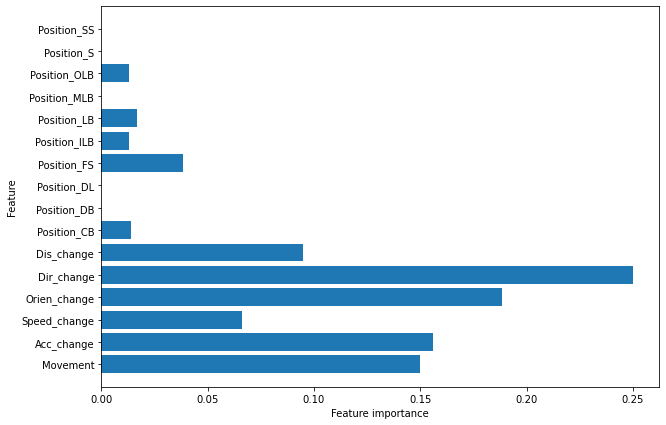

In [197]:
def plot_feature_importances(model, n_features, feature_names):
    plt.rcParams["figure.figsize"] = (10,7)

    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

#put the importances into a dataframe    
#importances = pd.DataFrame({'feature':matrix.columns,'importance':np.round(decision_tree.feature_importances_,3)})
#importances = importances.sort_values('importance',ascending=False).set_index('feature')

feature_names = matrix.columns.values


#features = feature_names[1:]
plot_feature_importances(decision_tree, len(feature_names), feature_names)

In [156]:
#Confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
predictions = cross_val_predict(decision_tree, x_train, y_train, cv=3)
confusion_matrix(y_train, predictions)

array([[ 25, 101],
       [100, 326]])

The first row is about the not-completed-predictions: 25 passes were correctly classified as not completed (called true negatives) and 101 where wrongly classified as not completed (false negatives).

The second row is about the completed-predictions: 100 patients were wrongly classified as completed (false positives) and 326 were correctly classified as completed (true positives).

In [157]:
from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(y_train, predictions))
print("Recall:",recall_score(y_train, predictions))

Precision: 0.7634660421545667
Recall: 0.7652582159624414


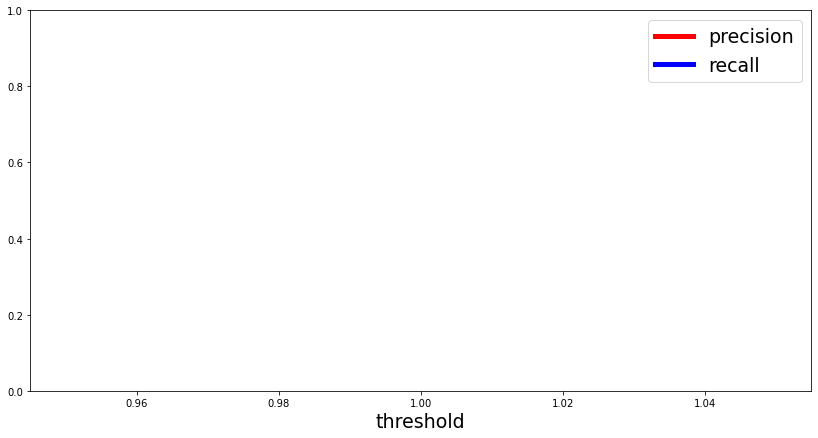

In [159]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores = decision_tree.predict_proba(x_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(y_train, y_scores)

def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

In [165]:
from sklearn.metrics import roc_curve
# compute true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_scores)

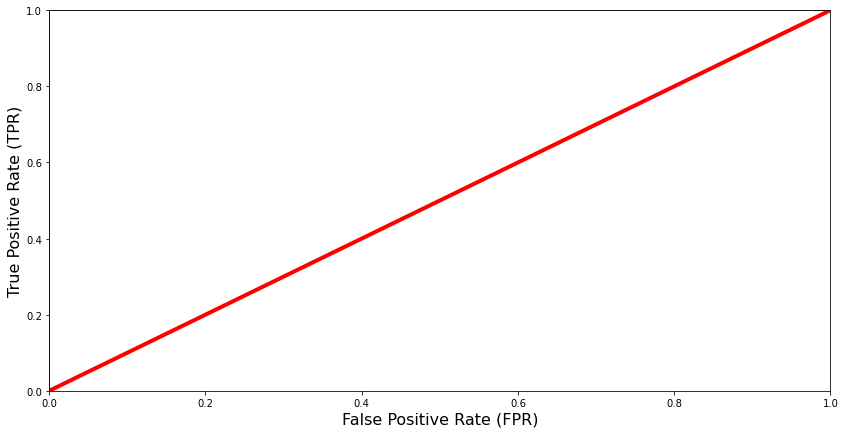

ROC-AUC-Score: 1.0


In [167]:
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

from sklearn.metrics import roc_auc_score
r_a_score = roc_auc_score(y_train, y_scores)
print("ROC-AUC-Score:", r_a_score)

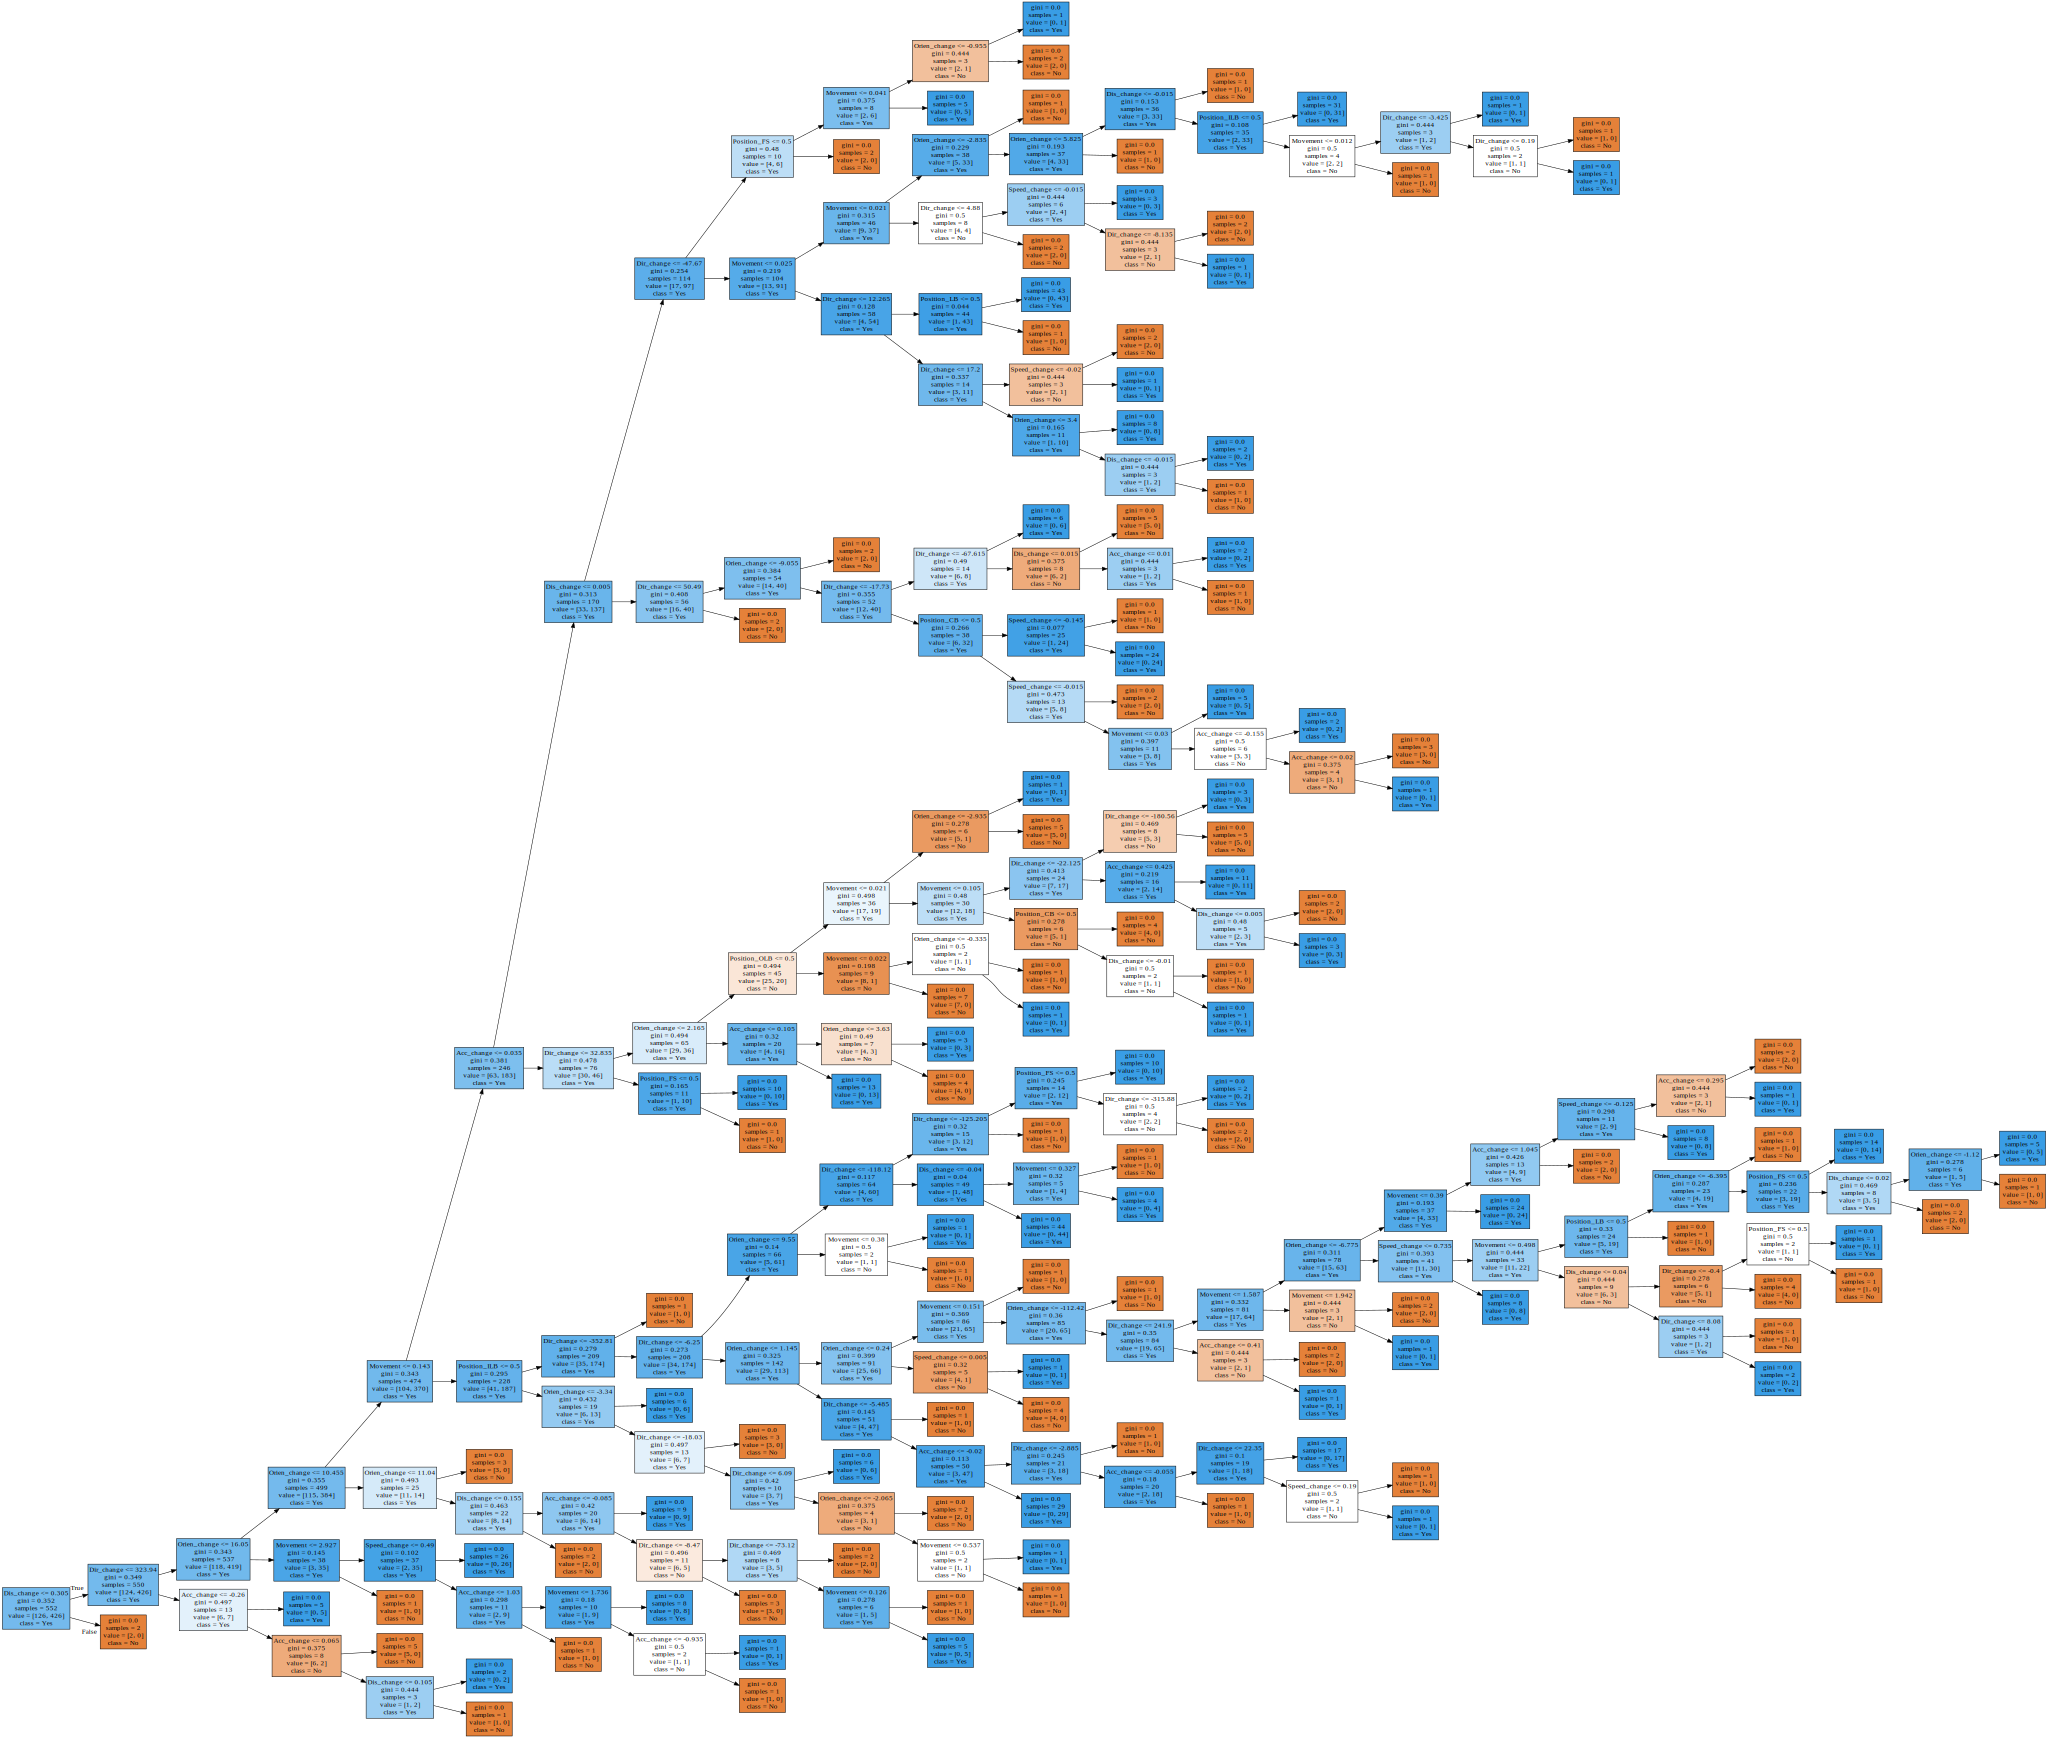

In [171]:
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source
from IPython.display import display


tree = export_graphviz(decision_tree, out_file=None, feature_names=feature_names, class_names=['No','Yes'], filled = True, rotate = True)
graph = Source(tree)
graph

In [172]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(decision_tree, random_state=1).fit(x_train, y_train)
eli5.show_weights(perm, feature_names = x_train.columns.tolist())

Weight,Feature
0.2362 ± 0.0387,Movement
0.2185 ± 0.0223,Orien_change
0.1877 ± 0.0197,Dir_change
0.1681 ± 0.0147,Acc_change
0.1014 ± 0.0162,Dis_change
0.0409 ± 0.0106,Speed_change
0.0254 ± 0.0100,Position_ILB
0.0214 ± 0.0035,Position_FS
0.0181 ± 0.0065,Position_CB
0.0134 ± 0.0054,Position_OLB


In [194]:
import shap  # package used to calculate Shap values

#arbitrarily looking at row 700
row_to_show = 67
data_for_prediction = x_train.iloc[row_to_show]

# Create object that can calculate shap values
explainer = shap.TreeExplainer(decision_tree)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

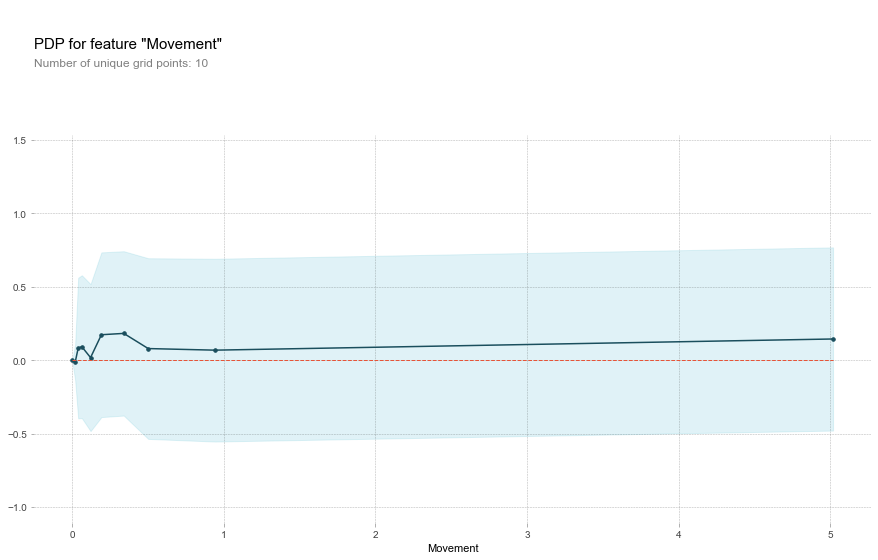

In [189]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=decision_tree, dataset=x_train, model_features=x_train.columns.tolist(), feature='Movement')

# plot it
pdp.pdp_plot(pdp_goals, 'Movement')
plt.show()

In [ ]:
#Future analsyis uses

In [20]:
def get_distance(x2,y2,x1,y1):
    return np.sqrt(((x2-x1)**2) + ((y2-y1)**2))

In [ ]:
#distances of players from the football

playerdict = {}

for index, row in motion_plays.iterrows():
    players = row.displayName
    position = row.position
    if row.displayName == 'Football':
        footballx = row['x']
        footbally = row['y']
    value = get_distance(playerx, playery, footballx, footbally)
    playerdict[players] = value
print(playerdict)
        
#distance_from_players_to_ball(motion_plays)

In [ ]:
#distances of players from the football
def distance_from_players_to_ball(df):
    players = []
    playerx = []
    playery = []
    footballx = []
    footbally = []
    playerdict = {}
    for index, row in df.iterrows():
        players.append(row.displayName)
        playerx.append(row['x'])
        playery.append(row['y'])
        if row.displayName == 'Football':
            footballx.append(row['x'])
            footbally.append(row['y'])
    for i, value in enumerate(players):
        distance = get_distance(playerx[i], playery[i],footballx[i], footbally[i])
        playerdict[value] = distance 
    print(playerdict)
        
    #print(get_distance(playerx, playery,footballx, footbally))
        
distance_from_players_to_ball(motion_plays)

In [ ]:
#finding the coverages

def find_coverages(row):
    DBs = ['S', 'FS','SS','CB','DB']
    if row.event == 'ball_snap':
        #if row.pos in DBs:
        if ((row.position == 'FS') | (row.position == 'SS')) & (17.6 < row.y < 35):
            return ('cover 1 or cover 3')
        else:
            return ('cover 2 or cover 4')    

In [ ]:
coverages = ['cover 1 or cover 3', 'cover 2 or cover 4']
coverage_plays = set(week_filtered[week_filtered['coverage'].isin(coverages)]['playId'])


In [ ]:
week_filtered['coverage'] = week_filtered.apply(find_coverages, axis=1)
week_filtered.head()